# Import libraries #

In [10]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
from jinja2.compiler import F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import time

## Download MNIST ##

In [11]:
# Define a transform to convert PIL images to tensors.
transform = transforms.ToTensor()

# Downloading the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Some DataSet Examination ##

Label is: 5; background value is 0.0; max value  is : 1.0, min value  is : 0.0


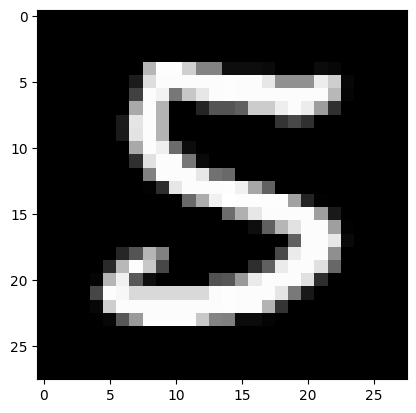

In [12]:
random_sample = random.randint(1,2000)
data,label = train_dataset[random_sample]
data_np = data.numpy()
min_val, max_val = data_np.min(), data_np.max()
median_val = np.median(data_np)

print(f"Label is: {label}; background value is {median_val}; max value  is : {max_val}, min value  is : {min_val}")

plt.imshow(data.squeeze().numpy(), cmap='gray')
plt.show()

## Define CNN ##


In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x) # softmax is included in the loss function
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is in use")

model = ConvNet().to(device)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda is in use


## Training Loop ##

In [18]:
# Training loop:
epochs = 5
batch_size = 64

# Data Split
# Define the split ratio
train_ratio = 0.8
val_ratio = 0.2

# Compute sizes for each split
total_size = len(train_dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size  # ensures the sum is equal to total_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
# Create dataloaders for each subset
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


train_losses = []
val_losses = []
train_correct = []
val_correct = []

total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(f"Number of iterations per epoch: {n_iterations}")

start_time = time.time()
for epoch in range(epochs):
    trn_corr = 0
    val_corr = 0
    for b,(images,labels) in enumerate(train_loader):
    # Train
        # Transfer data to device:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass:
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Track the learning
        predicted = torch.max(outputs.data, 1)[1] # sum correct predictions
        batch_corr = (predicted ==labels).sum().item() # how many correct from this batch
        trn_corr += batch_corr # keep track as we go along

        # Back propagation:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print results:
        if b%600==0:
            print(f'Epoch {epoch+1}/{epochs} Batch: {b} Loss: {loss.item():.4f}')
        train_losses.append(loss)
        train_correct.append(trn_corr)
    # Validation
    with torch.no_grad():
        for b,(val_images,val_labels) in enumerate(val_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            outputs_val = model(val_images)
            # Track the learning
            predicted = torch.max(outputs_val.data, 1)[1] # sum correct predictions
            val_corr = (predicted ==val_labels).sum().item() # how many correct from this batch
            val_corr += batch_corr # keep track as we go along
        loss=criterion(outputs_val,val_labels)
        val_losses.append(loss)
        val_correct.append(val_corr)

finish_time = time.time()
total_time = finish_time - start_time
print(f"Training took time: {total_time/60} minutes")

Number of iterations per epoch: 938
Epoch 1/5 Batch: 0 Loss: 0.0559
Epoch 1/5 Batch: 600 Loss: 0.0176
Epoch 2/5 Batch: 0 Loss: 0.0072
Epoch 2/5 Batch: 600 Loss: 0.0040
Epoch 3/5 Batch: 0 Loss: 0.0124
Epoch 3/5 Batch: 600 Loss: 0.0114
Epoch 4/5 Batch: 0 Loss: 0.0233
Epoch 4/5 Batch: 600 Loss: 0.0839
Epoch 5/5 Batch: 0 Loss: 0.0318
Epoch 5/5 Batch: 600 Loss: 0.0710
Training took time: 0.8512174844741821 minutes
